In [1]:
%load_ext autoreload
%autoreload 2
import torch
import scipy.ndimage
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from omegaconf import OmegaConf
import pytorch_lightning as pl
import torchvision.models as models


from brainage.model.model2d import AgeModel2DSlices
from brainage.dataset.dataset2d import SliceDataset

In [70]:
ckpt = '/is/ei/thepp/projects/brainage/brainage/model/outputs/2020-07-16/21-30-36/my-project/1fqx8m7y/checkpoints/epoch=68.ckpt'
out_dir = Path('../../outputs/plots')
out_dir.mkdir(exist_ok=True)

In [3]:
model = AgeModel2DSlices.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
model.eval()

AgeModel2DSlices(
  (net): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [4]:
cfg = OmegaConf.load('../../config/config.yaml')
with Path(cfg.dataset.val).open('r') as f:
    val_keys = [l.strip() for l in f.readlines()]

info_df = pd.read_feather(cfg.dataset.info)
info_df = info_df[(info_df['slice']>55) & (info_df['slice']<57)]
info_val = info_df[info_df.key.isin(val_keys)]
ds_val = SliceDataset(cfg.dataset.data, 
                      info=info_val, preload=cfg.dataset.preload, zoom=2.5)

loading data to memory ...
finished 53.48 MB - 3.19s 


In [5]:
class GradCam(torch.nn.Module):
    def __init__(self):
        super(GradCam, self).__init__()
        model = AgeModel2DSlices.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
        self.features_conv = torch.nn.Sequential(*list(model.net.children())[:-2])
        self.avgpool = model.net.avgpool
        self.fc = model.net.fc
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        y = self.features_conv(x)

        # register the hook
        h = y.register_hook(self.activations_hook)

        y = self.avgpool(y)
        y = y.view((1, -1))
        y = self.fc(y)
        #y = F.softmax(y, dim=1)
        return y

    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [45]:
cam = GradCam()
a = cam.eval()

In [74]:
idx = 355
sample = ds_val[idx]

predicted age (model) 50.0 chron. age 59.0


predicted age (model) 42.5 chron. age 52.0
predicted age (grad cam) 42.5, class 9
(8, 10) (250, 312)
predicted age (model) 37.5 chron. age 25.0
predicted age (grad cam) 37.5, class 7
(8, 10) (250, 312)
predicted age (model) 62.5 chron. age 64.0
predicted age (grad cam) 62.5, class 17
(8, 10) (250, 312)
predicted age (model) 42.5 chron. age 45.0
predicted age (grad cam) 42.5, class 9
(8, 10) (250, 312)
predicted age (model) 62.5 chron. age 65.0
predicted age (grad cam) 62.5, class 17
(8, 10) (250, 312)
predicted age (model) 65.0 chron. age 70.0
predicted age (grad cam) 65.0, class 18
(8, 10) (250, 312)
predicted age (model) 52.5 chron. age 47.0
predicted age (grad cam) 52.5, class 13
(8, 10) (250, 312)
predicted age (model) 30.0 chron. age 26.0
predicted age (grad cam) 30.0, class 4
(8, 10) (250, 312)
predicted age (model) 30.0 chron. age 32.0
predicted age (grad cam) 30.0, class 4
(8, 10) (250, 312)
predicted age (model) 62.5 chron. age 56.0
predicted age (grad cam) 62.5, class 17
(8, 

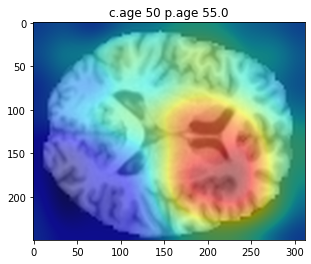

In [78]:
hmaps = []
imgs = []
for idx in range(100):
    sample = ds_val[idx]

    # prediction
    input = torch.tensor(sample['data'][np.newaxis, ...]).float()
    y = model(input)
    y = F.softmax(y, dim=1)
    model_prediction = torch.argmax(y)*2.5+20
    print(f'predicted age (model) {model_prediction} chron. age {sample["label"][0]:.1f}')

    # forward prediction 
    pred = cam(input)
    cl = torch.argmax(pred)
    p_age = cl*2.5+20
    c_age = sample['label'][0]
    print(f'predicted age (grad cam) {p_age}, class {cl}')

    # compute gradients
    pred[:,cl].backward()
    gradients = cam.get_activations_gradient()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = cam.get_activations(input).detach()
    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # resample heatmap to original size
    hmap = heatmap.squeeze().numpy()
    img = sample['data'][0]
    zoom = np.array(img.shape)/np.array(hmap.shape)
    heatmap_zoomed = scipy.ndimage.zoom(hmap, zoom)

    print(heatmap.numpy().shape, heatmap_zoomed.shape)

    plt.imshow(img, cmap='gray')
    heatmap_filtered = np.copy(heatmap_zoomed)
    #hmap_filtered[hmap_filtered < 0.0] = 0
    plt.title(f'c.age {c_age} p.age {p_age}')
    plt.imshow(heatmap_filtered, alpha=0.5, cmap='jet')
    plt.savefig(out_dir/f'heatmap{str(idx).zfill(4)}.png')

    # store results
    imgs.append(img)
    hmaps.append(heatmap_filtered)


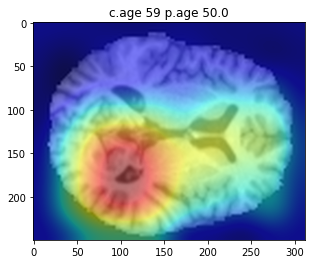

In [72]:
plt.imshow(img, cmap='gray')
heatmap_filtered = np.copy(heatmap_zoomed)
#hmap_filtered[hmap_filtered < 0.0] = 0
plt.title(f'c.age {c_age} p.age {p_age}')
plt.imshow(heatmap_filtered, alpha=0.5, cmap='jet')
plt.savefig(out_dir/'test.png')

torch.Size([8, 10])


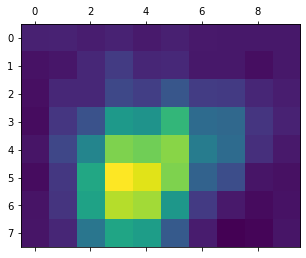

In [26]:
# draw the heatmap
plt.matshow(heatmap.squeeze())
print(heatmap.squeeze().shape)

64


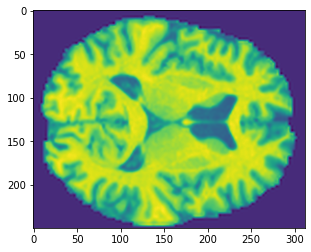

In [44]:
plt.imshow(sample['data'][0].astype(np.float32))
print(sample['label'][0])

Text(0.5, 1.0, 'overlay mean heatmap (min-max-normalized) \n background mean img')

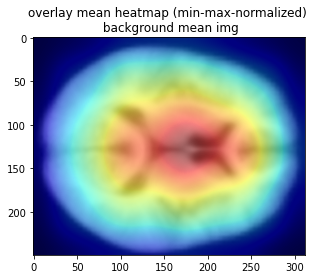

In [95]:
hmap_mean = np.mean(np.stack([(m-m.min())/(m.max()-m.min()) for m in hmaps]), axis=0)
img_mean = np.mean(np.stack([m for m in imgs]), axis=0)
plt.imshow(img_mean, cmap='gray')
plt.imshow(hmap_mean, cmap='jet', alpha=0.5)
plt.title('overlay mean heatmap (min-max-normalized) \n background mean img')

(array([ 256.,  363.,  466.,  532., 1174., 2196., 1717., 1492., 1617.,
         879.]),
 array([20. , 25.2, 30.4, 35.6, 40.8, 46. , 51.2, 56.4, 61.6, 66.8, 72. ]),
 <a list of 10 Patch objects>)

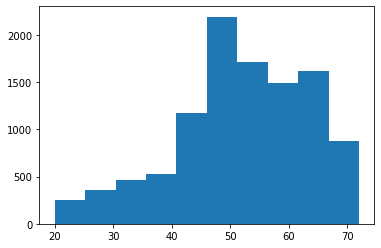

In [70]:
plt.hist(info_df['age'])